In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

In [3]:
def process_eval_file(file_name:str):
    
    try:
        eva_results = pd.read_excel(f'{file_name}.xlsx')
    except:
        return None
    
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR.replace('[',''), axis=1)
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR_processed.replace(']',''), axis=1)
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR_processed.split(','), axis=1)

    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record.replace('[',''), axis=1)
    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record_processed.replace(']',''), axis=1)
    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record_processed.split(','), axis=1)

    return eva_results

In [ ]:
# Map config_number to initial_state type
config_init_state_map = {1: 'uniform'
                        , 2: 'equi_dist'
                        , 3: 'left_skwd'
                        , 4: 'right_skwd' }

In [24]:
eval_f_list_original = {}

for i in range(4):

    name_prefix = 'experiments/eval_results/original_experiment_results_para_config_'
    f_num = i+1
    f_name = name_prefix + str(f_num)
    
    if process_eval_file(f_name) is not None:
        eval_f_list_original[config_init_state_map[i+1]] = process_eval_file(f_name)

In [92]:
# Create seperate evaluation result datasets from the original algorithm 
# for each type of initial state set
eval_full_file_original_uni   = eval_f_list_original['uniform']
eval_full_file_original_equl  = eval_f_list_original['equi_dist']
eval_full_file_original_left  = eval_f_list_original['left_skwd']
eval_full_file_original_right = eval_f_list_original['right_skwd']

In [25]:
eval_f_list_modified = {}

for i in range(4):
    
    name_prefix = 'experiments/eval_results/modified_experiment_results_para_config_'
    f_num = i+1
    f_name = name_prefix + str(f_num)
    
    if process_eval_file(f_name) is not None:
        eval_f_list_modified[config_init_state_map[i+1]] = process_eval_file(f_name)

In [26]:
# Create seperate evaluation result datasets from the modified algorithm 
# for each type of initial state set
eval_full_file_modified_uni   = eval_f_list_modified['uniform']
eval_full_file_modified_equl  = eval_f_list_modified['equi_dist']
eval_full_file_modified_left  = eval_f_list_modified['left_skwd']
eval_full_file_modified_right = eval_f_list_modified['right_skwd']

In [41]:
def create_action_sr_cummulative_df(temp_original_df, temp_modified_df, init_state_type:str):

    # Filter for the parameter-configurations available in both modified and original
    # evaluation results
    min_exp_count = min(temp_original_df.shape[0], temp_modified_df.shape[0])
    df_configs    = temp_original_df if temp_original_df.shape[0] == min_exp_count else temp_modified_df
    df_configs    = df_configs.iloc[:,:5]
    
    temp_original_df = df_configs.merge( right     = temp_original_df
                                        , left_on  = ['S','Actions','Roll-outs','Significance','run']
                                        , right_on = ['S','Actions','Roll-outs','Significance','run']
                                        , how      = 'left')

    temp_modified_df = df_configs.merge( right     = temp_modified_df
                                        , left_on  = ['S','Actions','Roll-outs','Significance','run']
                                        , right_on = ['S','Actions','Roll-outs','Significance','run']
                                        , how      = 'left')

    tot_exp_original = temp_original_df.shape[0]
    tot_exp_modified = temp_modified_df.shape[0]

    # Compute the 'SR' and 'Cummulative SR' values: original algo.
    temp_original_df.loc[:,'positive_SR_idx'] = temp_original_df.apply(lambda row: [idx for idx,val in enumerate(row.SR_processed) if float(val)>0], axis=1)
    temp_original_df.positive_SR_idx = temp_original_df.positive_SR_idx.apply(lambda cell: np.nan if len(cell)==0 else cell)
    temp_original_df.dropna(subset=['positive_SR_idx'],inplace=True)

    if temp_original_df.shape[0] == 0:
        print(f'There are no successful experiments for initial states with {init_state_type} for the original algorithm.')
    else:
        temp_original_df.loc[:, 'action_SR_pairs'] = temp_original_df.apply(lambda row: [(int(row.action_record_processed[val]), round(float(row.SR_processed[val]), 4)) for val in row.positive_SR_idx ] , axis=1)

        temp_original_df_2 = temp_original_df.copy()

        # Only select the first action count (if multiple SR-action pairs available) | for cummulative SR plot
        temp_original_df_2.action_SR_pairs = temp_original_df.action_SR_pairs.apply(lambda cell: [cell[0]])

        # Data for cummulative SR plot
        action_sr_pair_list_original_2 = []
        for experiment in temp_original_df_2.action_SR_pairs.values:
            for action_sr_pair in experiment:
                action_sr_pair_list_original_2.append(action_sr_pair)
                
        action_sr_pairs_original_2 = np.array(action_sr_pair_list_original_2)

        action_sr_pairs_original_df_2 = pd.DataFrame(action_sr_pairs_original_2)
        action_sr_pairs_original_df_2.columns = ['actions', 'sr']
        action_sr_pairs_original_df_2.sort_values('actions', inplace=True)    

        # Compute the 'pct_sr' and 'cum_pct_sr' values to use for the evaluation plot
        action_sr_pairs_original_df_2.loc[:,'pct_sr'] = 1/ tot_exp_original
        action_sr_pairs_original_df_2.loc[:,'cum_pct_sr']  = action_sr_pairs_original_df_2.pct_sr.cumsum()
        action_sr_pairs_original_df_2.loc[:, 'algorithm'] = 'original'
        action_sr_pairs_original_df_2.loc[:, 'state_set'] = init_state_type


    # Compute the 'SR' and 'Cummulative SR' values: modified algo.
    temp_modified_df.loc[:,'positive_SR_idx'] = temp_modified_df.apply(lambda row: [idx for idx,val in enumerate(row.SR_processed) if float(val)>0], axis=1)
    temp_modified_df.positive_SR_idx = temp_modified_df.positive_SR_idx.apply(lambda cell: np.nan if len(cell)==0 else cell)
    temp_modified_df.dropna(subset=['positive_SR_idx'],inplace=True)

    if temp_modified_df.shape[0] == 0:
         print(f'There are no successful experiments with initial state size {num_init_states} for the modified algorithm.')
    else:
        temp_modified_df.loc[:, 'action_SR_pairs'] = temp_modified_df.apply(lambda row: [(int(row.action_record_processed[val]),round(float(row.SR_processed[val]),4)) for val in row.positive_SR_idx ] , axis=1)

        temp_modified_df_2 = temp_modified_df.copy()    
    
        # Only select the first action count (if multiple SR-action pairs available) | for cummulative SR plot    
        temp_modified_df_2.action_SR_pairs = temp_modified_df.action_SR_pairs.apply(lambda cell: [cell[0]])

        # Data for cummulative SR plot
        action_sr_pair_list_modified_2 = []
        for experiment in temp_modified_df_2.action_SR_pairs.values:
            for action_sr_pair in experiment:
                action_sr_pair_list_modified_2.append(action_sr_pair)
                
        action_sr_pairs_modified_2 = np.array(action_sr_pair_list_modified_2)

        action_sr_pairs_modified_df_2 = pd.DataFrame(action_sr_pairs_modified_2)
        action_sr_pairs_modified_df_2.columns = ['actions', 'sr']
        action_sr_pairs_modified_df_2.sort_values('actions', inplace=True)

        # Compute the 'pct_sr' and 'cum_pct_sr' values to use for the evaluation plot
        action_sr_pairs_modified_df_2.loc[:,'pct_sr'] = 1/ tot_exp_modified
        action_sr_pairs_modified_df_2.loc[:,'cum_pct_sr']  = action_sr_pairs_modified_df_2.pct_sr.cumsum()
        action_sr_pairs_modified_df_2.loc[:, 'algorithm'] = 'modified'
        action_sr_pairs_modified_df_2.loc[:, 'state_set'] = init_state_type

    if temp_original_df.shape[0]>0 and temp_modified_df.shape[0]>0:
        return pd.concat([action_sr_pairs_original_df_2, action_sr_pairs_modified_df_2])
    elif temp_original_df.shape[0]>0 and temp_modified_df.shape[0]==0:
        return action_sr_pairs_original_df_2
    elif temp_original_df.shape[0]==0 and temp_modified_df.shape[0]>0:
        return action_sr_pairs_modified_df_2
    else:
        print(f'Experiments from {init_state_type} have not found any sufficient policies!')
        return None

In [42]:
uniform_df      = create_action_sr_cummulative_df(eval_full_file_original_uni, eval_full_file_modified_uni, 'uniform selection')
equl_part_df    = create_action_sr_cummulative_df(eval_full_file_original_equl, eval_full_file_modified_equl, 'equal partitions')
left_skewed_df  = create_action_sr_cummulative_df(eval_full_file_original_left, eval_full_file_modified_left, 'left skewed')
right_skewed_df = create_action_sr_cummulative_df(eval_full_file_original_right, eval_full_file_modified_right, 'right skewed')

There are no successful experiments for initial states with equal partitions for the original algorithm.
There are no successful experiments for initial states with left skewed for the original algorithm.
There are no successful experiments for initial states with right skewed for the original algorithm.


In [44]:
# Create the final dataframe with evaluation results from all experiments
final_eval_df = pd.concat([uniform_df, equl_part_df, left_skewed_df, right_skewed_df])

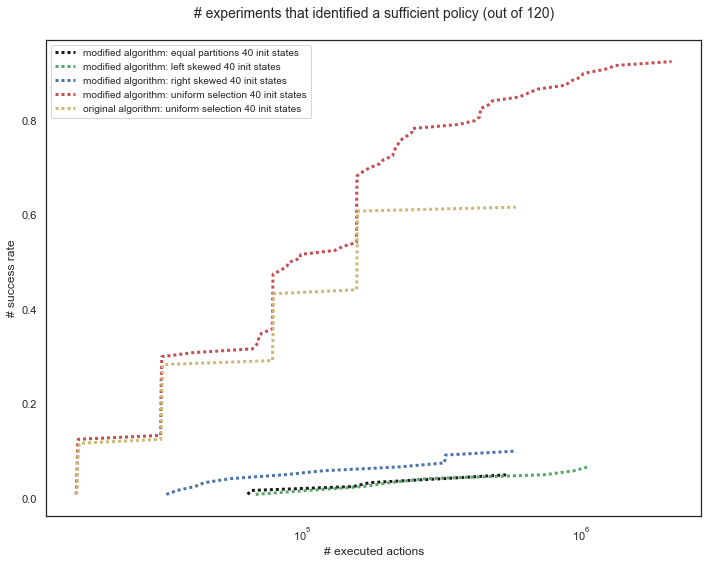

In [106]:
# Select the available 'algorithm-initial state' pairs
available_combi = final_eval_df.groupby(['algorithm', 'state_set']).size().reset_index().apply(lambda row: (row['algorithm'], row['state_set']), axis=1)

# Create the cummulative SR evaluation plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['k', 'g', 'b', 'r', 'y']

for i, combi in enumerate(available_combi):
    algo, state = combi
    temp_df = final_eval_df.loc[(final_eval_df.algorithm == algo) & (final_eval_df.state_set == state)]

    ax.plot(temp_df.actions
        , temp_df.cum_pct_sr
        , linestyle=':'
        , linewidth =  3
        , c = colors[i]
        , dashes=(1, 1)
        , label = f"{algo} algorithm: {state} 40 init states")

plt.ylabel('# success rate')
plt.xlabel('# executed actions')
plt.title(f"# experiments that identified a sufficient policy (out of 120)\n", fontsize=14)
plt.legend(loc = 'upper left', fontsize = 10)
plt.xscale('log')
plt.tight_layout()